<a href="https://colab.research.google.com/github/AlekZivkovic/pp_Game_of_Life/blob/main/PP_Game_of_Life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projekat 1.1**

Semafori, Kljucevi, conditions

Unesite velicinu matrice 3
Unesite broj generacija 5
Unesite broj delova: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


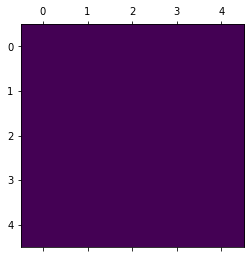

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


#Pravi se random matrica, moze da se implemetira i da se ucitava kako korisnik hoce, ali je ovako bilo lakse za testiranje
n = int(input("Unesite velicinu matrice "))
ludnica_veri_kul_matrica = []
for i in range(n):
    matrica_red = []
    for j in range(n):
        matrica_red.append(random.randint(0, 1))
    ludnica_veri_kul_matrica.append(matrica_red)
iteracije = int(input("Unesite broj generacija "))

#Ovde se bira koja implementacija se pokrece *impl (regex xD)
rez = cetvrtaImpl(iteracije, ludnica_veri_kul_matrica)

anim = animate(rez);
HTML(anim.to_html5_video())

Prva implementacija

In [ ]:

import numpy as np
import threading

#podaci
matrica=[]
BROJ_SUSEDA=8

#krajna niz nasih matrica
steps=[]

#Celije aka niti
celije=[]


#broj kao i mutex novih vrednosti u matrici
celMux=threading.Lock()
newCels=0


celRe=[] #broj suseda koji su procitali celiju
celReMutx=[] #mutex za izmenu date vrednosti prcitanih suseda
celUpSem=[] #oznacava nam dal kad procitamo poslednjeg suseda da mozemo da probudimo tu celiju da promeni vrednost

celSem=[]#ideja da bude 8 i kad dode do 0 da se blokira i ceka da se celija lepo sredi



newIter=threading.Condition() # zavrsetak pravljena stepa notify u celije nit
newCycle=threading.Condition() #pocinjane pravljene novog step-a u obsr niti se notify

#Ako je ćelija živa i ima 2 ili 3 živa suseda, u sledećoj iteraciji će biti živa
#Ako je ćelija mrtva i ima 3 živa suseda, u sledećoj iteraciji će biti živa

def dodaj(korak):
  global steps

  for i in range(len(matrica)):
    var=[]
    for j in range(len(matrica)):
      var.append(matrica[i][j])  
    steps[korak].append(var)

def kodr(kord):
  n=len(matrica[0])
  abkord= (n+kord) % n
  return abkord
  
def read(ti,tj):
  global celRe
  
  count=0
  for i in range(-1,2):
    for j in range(-1,2):
      if i == 0 and j == 0:
        continue 
      ki=kodr(ti+i)
      kj=kodr(tj+j)
      celSem[ki][kj].acquire()
      if matrica[ki][kj] == 1:
        count+=1

      celReMutx[ki][kj].acquire()
      celRe[ki][kj]+=1

      if celRe[ki][kj] == BROJ_SUSEDA : 
        celReMutx[ki][kj].release()
        celUpSem[ki][kj].release()
      else:
         celReMutx[ki][kj].release()
      
  if count < 2:
    return 0
  elif count > 3:
    return 0  
  elif  matrica[ti][tj] == 1 and (count==2 or count == 3):
    return 1
  elif matrica[ti][tj] == 0 and count== 3:
    return 1

  return 0


def celija(ti,tj,n):
  global matrica, celRe,newCels
  i=ti
  j=tj
  for iter in range(n):
    
    nval=read(ti,tj)
    #kada acquire ovaj sem to tehnicki znaci da su nasu celiju svi susedi procitali i daje mozemo da je zamenimo
    celUpSem[i][j].acquire()
    
    #resetovanje suseda koji su procitali
    celReMutx[i][j].acquire()
    celRe[i][j]=0
    celReMutx[i][j].release()

    #setovanje nove vrednosti u matricu 
    #ukoliko broj novih vrednosti dostigne vrednost len^2 matrice govorimo observeru da je jedan step done
    celMux.acquire()
    matrica[i][j]=nval
    for pove in range(BROJ_SUSEDA):
      celSem[i][j].release()
    newCels+=1
    celMux.release()
    if newCels == len(matrica)*len(matrica) :
        newIter.acquire()
        newIter.notifyAll()
        newIter.release()
        #ovo radimo da ne bi doslo do dedlocka
        if iter == n-1:
          continue

    #odpocinanje novog ciklusa
    newCycle.acquire()
    newCycle.wait()
    newCycle.release()
    



def observer(n):
  global steps,newCels
  
  for i in range(n):
  
    newIter.acquire()
    #ceka sve dok se sve celije ne izmene
    newIter.wait()
  
    dodaj(i+1)

    #resetovanje broja novi celija 
    celMux.acquire()
    newCels=0
    celMux.release()

    #cisto da pratimo koliko ih je izvrsio

    newIter.release()

    #oglasavanje svim celijama da je zavrsen jedan ciklus i da mogu da krenu na sledecu iter
    newCycle.acquire()
    newCycle.notifyAll()
    newCycle.release()


#n izvrsavanja, mat pocetna matrica
def prvaImpl(n,mat):
  global matrica,celIter,celije,celSem,newCels,celRe,celReMutx,celUpSem,steps

  del steps
  steps=[]
  celRe=[]
  celReMutx=[]
  celUpSem=[]
  celije=[]
  for i in range(n+1):
    steps.append([])

   
  matrica=np.array(mat)
  dodaj(0) 
  newCels=np.intc(0)
  
  #initCELIJA
  celRe=np.array([[0 for j in range(len(mat))] for i in range(len(mat))])
  celReMutx=np.array([[threading.Lock() for j in range(len(mat))] for i in range(len(mat))])
  celUpSem=np.array([[threading.Semaphore(0) for j in range(len(mat))] for i in range(len(mat))])
  celSem=np.array([[threading.Semaphore(BROJ_SUSEDA) for j in range(len(mat))] for i in range(len(mat))])
  celije=np.array([[threading.Thread(target=celija,args=(i,j,n) ) for j in range(len(mat))] for i in range(len(mat))])
  t2= threading.Thread(target=observer,args=(n,))

  t2.start()
  for i in range(len(mat)):
    for j in range(len(mat)):
        celije[i][j].start()

  
  t2.join
  for i in range(len(mat)):
    for j in range(len(mat)):
        celije[i][j].join()

  return np.array(steps)



# Implementacija 3
  Upotrebom procesa koji simuliraju po jednu ćeliju i sinhronizacijom redovima za poruke

  pokusaj sa clasama


In [ ]:
import multiprocessing as mp
from multiprocessing import JoinableQueue
from multiprocessing import Queue
from queue import Empty
import numpy as np
import ctypes as c

#Lista ques i-ti elem pripada i-toj celiji
celQues=[]
#obsQue-> Predstavlja komunikaciju sa servisom (observerom) koji skladisti dobijene vrednosti
obsQue=JoinableQueue()

#sluzi nam da obavestimo observer da su celije zavrsile
emptQue=mp.Queue()

#deljena mem za observer
mp_arr=[]
SUS_BROJ=8

#vraca listu suseda za cel[ti][tj]
def getNeighbor(ti,tj,n,m):
  arr=[]
  for i in range(-1,2):
    for j in range(-1,2):
      if i== 0 and j== 0 :
        continue
      ki= (n+ti+i) % n
      kj= (m+tj+j) % m
      arr.append((ki,kj))
  return np.array(arr)


#funkcija pomocu koje celije dobijaju novu vrednost
# Caller celija prolazi kruzno korz svoje susede pri cemu kada get-uje elem
# iz sus que proverava i iteraciju datog sus celije. To radimo u slucaju
# da je nasa caller celija na vecoj iter od sus celije, nasa calller celija
# pobedi svaki put u stanju trke, pri cemu data vrednost sus nije validna i 
# ujedno moze doci do dedlock-a. Iter prosledjujemo zajedno sa vred u celQue
#->neigh - lista suseda caller celije
#-> val - vrednost caller celije
#-> ti,tj - kordinate
#-> iter - trenutna iteracija caller celije 
def readIV2(neigh,val,ti,tj,iter):
  #skladistenje zivih suseda
  count=0
  #var u kojoj smestamo vrednosti iz ques od suseda
  red=(-1,-1)
  #niz u kojem smestamo procitanje susede
  read=[]
  #promenjiva za neuspesno citanje
  no=0
  #brojac
  j=0
  while len(read) < len(neigh) :
    i=j%len(neigh)
    que=celQues[neigh[i][0]][neigh[i][1]]
    #ukoliko smo vec procitali elem iz que za datog suseda preskacemo ga
    if i in read:
      j+=1
      no+=1
      #ukoliko smo pri citanju susednih celija obisli sve hocemo da pustimo
      # susede da upisu vrednosti u njihove que-ove
      continue

    try:
      red= que.get(timeout=2)
      if red !=(-1,-1):
        #ukoliko su na istoj iter prihvatamo vrednost
        if red[1] == iter:
          read.append(i)        
          count+=red[0]
          red=(-1,-1)
          no=0
          que.task_done()
        else :
          #potrebno je pri vracanju vrednsti u que od sus cel da uradimo
          #task done jer put poveca brojac za join
          que.put(red)
          que.task_done()
          no+=1
    except Empty:
      j+=1
      continue   
    j+=1
  if count < 2:
    return 0
  elif count > 3:
    return 0  
  elif  val == 1 and (count==2 or count == 3):
    return 1
  elif val == 0 and count== 3:
    return 1

  return 0    
    



def cell(i,j,neigh,vred,n):
  val=vred
  myQue=celQues[i][j]

  for iter in range(n):
   for _ in range(SUS_BROJ):
    myQue.put((val,iter))
   
   val=readIV2(neigh,val,i,j,iter)
  #radimo join da bi smo blokirali celiju
  #dok svi susedi procitaju njenu vrednost
   myQue.join() 
   
   obsQue.put((i,j,iter,val)) 
     
    

def obsrv(iter,red,kolon):
  #init deljive memorije
  ar_ptr=np.frombuffer(mp_arr.get_obj(), dtype="int32")
  arr1=ar_ptr.reshape((iter,red,kolon))

  done=0
  while True:
    try:
      val=obsQue.get(timeout=3)
      arr1[val[2]+1][val[0]][val[1]]=val[3]
    except Empty:
      try:
        done=emptQue.get(timeout=2)
        if done == 1 :
          break
      except Empty:
        continue      


def trecaImpl(m,matrix):
  global celQues, obsQues,mp_arr

  #inicijalizacija
  celQues=np.array([[JoinableQueue(8) for j in range(len(matrix[0]))] for i in range(len(matrix))])
  
  obsQues=JoinableQueue()
  

  #init deljive memorije
  Iter,Red,Kolon =m+1,len(matrix),len(matrix[0])
  
  mp_arr=mp.Array(c.c_int,Iter*Red*Kolon)
  i_arr=np.frombuffer(mp_arr.get_obj(), dtype="int32")
  
  #ucitavanje pocetne matrice
  arr=i_arr.reshape((Iter,Red,Kolon))
  
  for i in range(len(matrix)):
    for j in range(len(matrix[0])):
      arr[0][i][j]=matrix[i][j]
       


  #pokretanje procesa
  p1=[[mp.Process(target=cell,args=(i,j,getNeighbor(i,j,len(matrix),len(matrix[0])),matrix[i][j],m )) for j in range(len(matrix[0]))]for i in range(len(matrix))]
  #dodaj obs
  p2=mp.Process(target=obsrv,args=(Iter,Red,Kolon))
  [[p1[i][j].start() for j in range(len(matrix[0]))] for  i in range(len(matrix))]
  p2.start()
  [[p1[i][j].join() for j in range(len(matrix[0]))] for  i in range(len(matrix))]
  emptQue.put(1)
  p2.join()
  return np.array(arr)  
  

# Implementacija 2
Threadovi i redovi

In [ ]:
import numpy as np
from queue import Queue, Empty
import threading
import random

#celije je matrica niti za svako polje (celiju) matrice, a redovi je matrica redova za svaku od tih celija, u red neke celije susedi upisuju svoje vrednosti kako bi ih celija ciji je red procitala
celije = []
redovi = []
#matrica_queue se koristi da bi se znalo da su sve niti zavrsile sa racunanjem trenutne vrednosti i da su spremne za sledecu iteraciju, takodje se koristi kako bi se bez problema upisala matrica u niz generacija
matrica_queue = Queue()
#red koji se koristi da se sacekaju sve niti na pocetku iteracije, da ne bi neka upisala u matrica_red pre nego sto neka druga nit izadje iz joina
blokiraj_niti_red = Queue()
matrica = []
niz_generacija = []
broj_generacije = 0
matrica_lock = threading.Lock()
broj_generacije_lock = threading.Lock()

#funkcija koja dodaje matricu u niz generacija
def dodaj_generaciju(n):
  global niz_generacija, matrica, broj_generacije
  for i in range(n):
    var=[]
    for j in range(n):
      var.append(matrica[i][j])  
    niz_generacija[broj_generacije].append(var)

#nit koja obradjuje celiju matrice
def celija_nit(thread_id, n, x, y, steps, curr_val):
    global matrica, matrica_queue
    for f in range(steps):
        #Cekaju se sve niti na pocetku iteracije da ne bi dolazilo do deadlocka ako neka nit ode do upisivanja u matrica_red a neka druga nit jos ne izadje iz joina, nit u joinu ce ostati zablokirana beskonacno
        #Uzima jednu vrednost iz niza, zove task_done da je procitala vrednost i ulazi u join gde ceka da sve niti procitaju vrednost iz reda, ovo je kao da nit kaze ja sam spremna da zapocnem iteraciju, cekam ostale
        #U redu ostaje onoliko vrednosti koliko ima niti koje nisu spremne za iteraciju
        #Slicno barijeri 
        blokiraj_niti_red.get()
        blokiraj_niti_red.task_done()
        blokiraj_niti_red.join()

        #Nit upisuje svoju vrednost u redove njenih suseda
        for i in range(x-1, x+2):
            for j in range(y-1, y+2):
                if(i == x and j == y):
                    continue
                redovi[i%n][j%n].put(curr_val)

        #Nit cita vrednosti iz svog reda (kojih ima 8) i gleda koliko oko nje ima zivih celija
        broj_zivih = 0
        for i in range(8):
            sused = redovi[x][y].get()
            if(sused == 1):
                broj_zivih += 1

        #Racuna se vrednost celije na osnovu broja zivih celija i njene vrednosti iz prosle iteracije
        if(broj_zivih < 2 or broj_zivih>3):
            curr_val = 0
        if((curr_val == 1 and (broj_zivih == 2 or broj_zivih == 3)) or (curr_val == 0 and broj_zivih == 3)):
            curr_val = 1

        #Nova vrednost se upisuje u matricu
        matrica_lock.acquire()
        matrica[x][y] = curr_val
        matrica_lock.release()

        #Nova vrednost se upisuje u matrica_red sto znaci da je ova nit zavrsila sa racunanjem vrednosti i da je njeno polje u matrici update-ovano, i preko joina ceka da sve celije zavrse sa racunanjem njihovih vrednosti
        #Kada sve celije zavrse sa racunanjem njihove vrednosti, ispisi_matricu_nit ce da ih pusti da nastave dalje u sledecu iteraciju
        matrica_queue.put(curr_val)
        matrica_queue.join()

#Nit koja se bavi sinhronizacijom i upisivanjem matrice u niz_generacija kada je to moguce         
def ispisi_matricu_nit(n, steps):
    global broj_generacije, matrica, niz_generacija, matrica_queue, blokiraj_niti_red
    for x in range(steps):
        #Nit iz matrica_red-a cita n^2 puta, sto znaci da ce se ovaj for zavrsiti samo kada su sve niti celija stigle do kraja, odnosno kada su zavrsile sa izracunavanjem svoje nove vrednosti
        for i in range(n**2):
            matrica_queue.get()

        #Znam da su sve niti zavrsile sa racunanjem nove vrednosti i znam da su novu vrednost ubacile u matricu, tako da sada treba da tu matricu upisem u niz_generacija i da broj generacija povecam za 1
        matrica_lock.acquire()
        dodaj_generaciju(n)
        matrica_lock.release()

        broj_generacije_lock.acquire()
        broj_generacije += 1
        broj_generacije_lock.release()

        #Spremam niz koji ce da blokira niti na pocetku iteracije dok sve niti ne izadju iz joina, nije bitno koju vrednost upisem u red jer se svakako ne koristi nigde, red sluzi samo da pokaze koliko je jos niti ostalo
        #u joinu, odnosno koliko niti jos nije krenulo u novu iteraciju, sprecava deadlock gde se nit zabode beskonacno u joinu jer je neka druga vec upisala svoju vrednost u matrica_red pa automatski ova ne moze da izadje iz
        #joina jer treba da se uradi dodatni task_done
        for i in range(n**2):
            blokiraj_niti_red.put(1)

        #Kada je sve spremno za sledecu iteraciju, radi se n^2 puta task_done da kaze da su sve vresnoti iz reda procitane, odnosno da su sve niti stigle do kraja iteracije i da mogu da predju na sledecu iteraciju
        for i in range(n**2):
            matrica_queue.task_done()


def drugaImpl(stepovi, mat):
    #Inicijalizujem sve potrebne vrednosti
    global matrica, niz_generacija, broj_generacije, celije, redovi
    matrica = mat
    n = len(matrica)
    for i in range(stepovi + 1):
        niz_generacija.append([])
    dodaj_generaciju(n)
    broj_generacije += 1
    ispisi_matricu_thread = threading.Thread(target = ispisi_matricu_nit, args = (n, stepovi))
    ispisi_matricu_thread.start()

    for i in range(0, n):
        celije_red = []
        redovi_red = []
        for j in range (0, n):
            thread = threading.Thread(target = celija_nit, args = (i*10 + j, n, i, j, stepovi, matrica[i][j]))
            celije_red.append(thread)
            queue = Queue()
            redovi_red.append(queue)
        celije.append(celije_red)
        redovi.append(redovi_red)

    #Spremam red koji blokira niti na pocetku iteracije, jer ako je red prazan doci ce do deadlocka jer ce svaka nit probati da getuje iz praznog reda gde ce da se blokira
    for i in range(n**2):
        blokiraj_niti_red.put(1)

    for i in range(n):
        for j in range(n):
            celije[i][j].start()

    for i in range(0, n):
        for j in range (0, n):
            celije[i][j].join()
        
    ispisi_matricu_thread.join()
    return np.array(niz_generacija)


# Implementacija 4
Proces pool

In [ ]:
import numpy as np
import random
import multiprocessing

#deljena matrica, sluzi samo za citanje vrednosti, procesi ne upisuju nista u nju
matrica = []
niz_generacija = []
broj_generacije = 0
matrica_lock = multiprocessing.Lock()

#izracunava novu vrednost za proslednjeno polje matrice, porlsedjuje se deljena matrica trenutnog stanja
def nova_vrednost(n, x, y, matrica):
    broj_zivih = 0
    matrica_lock.acquire()
    curr_val = matrica[x][y]
    matrica_lock.release()
    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
            if i == x and j == y:
                continue
            matrica_lock.acquire()
            sused = matrica[i%n][j%n]
            matrica_lock.release()
            broj_zivih += sused
    
    if(broj_zivih < 2 or broj_zivih>3):
        return 0
    if((curr_val == 1 and (broj_zivih == 2 or broj_zivih == 3)) or (curr_val == 0 and broj_zivih == 3)):
        return 1
    return 0

#Funkcija procesa, izracunava nove vrednosti za dodeljeni deo matrice
def izracunaj_deo_matrice(n, velicina_dela, pocetno_i, pocetno_j, matrica):
    ret_niz = []
    #Matricu gleda kao jednodimenzionalan niz da bi bilo lakse da se prodje kroz deomatrice, da ne moram svaki put da idem od pocetka matrice
    #Pravi tuple koji ima i i j koordinate i novu izracunatu vrednost
    for i in range(velicina_dela):
        index_niza = pocetno_i*n + pocetno_j + i
        nova_vr = nova_vrednost(n, index_niza//n, index_niza%n, matrica)
        ret_niz_tuple = (index_niza//n, index_niza%n, nova_vr)
        ret_niz.append(ret_niz_tuple)
    return ret_niz

#Dodaje generaciju na niz generacija
def dodaj_generaciju(n):
    global matrica, niz_generacija, broj_generacije
    for i in range(n):
        red = []
        for j in range(n):
            red.append(matrica[i][j])
        niz_generacija[broj_generacije].append(red)
    
#Unose se matrica, steps, i broj delova, odnosno koliko procesa treba da se napravi
def cetvrtaImpl(stepovi, mat):
    global matrica, niz_generacija, broj_generacije
    matrica = mat
    n = len(matrica)
    br_delova = int(input("Unesite broj delova: "))
    velicina_dela = n**2 // br_delova
    ostatak_velicine_dela = n**2 - (velicina_dela*br_delova)
    tmp_br_delova = br_delova - 1
    tren_velicina_dela = 0
    delovi_matrice = []
    tuple_deo_matrice = (velicina_dela, 0, 0)
    delovi_matrice.append(tuple_deo_matrice)
    izadji_flag = 0

    #Pravim niz tuplova koji ce da ima podatke o svakom procesu, odnosno koliko elemenata treba da obidje i pocetnu poziciju, odnosno odakle treba da krene daa obilazi elemente
    for i in range(n):
        if(izadji_flag == 1):
            break
        for j in range(n):
            if(tren_velicina_dela == velicina_dela):
                if(tmp_br_delova == 1):
                    izadji_flag = 1
                    nova_velicina_dela = velicina_dela + ostatak_velicine_dela
                    tuple_deo_matrice = (nova_velicina_dela, i, j)
                    delovi_matrice.append(tuple_deo_matrice)
                    break
                else:
                    tuple_deo_matrice = (velicina_dela, i, j)
                    delovi_matrice.append(tuple_deo_matrice)
                tren_velicina_dela = 0
                tmp_br_delova -= 1
            tren_velicina_dela += 1

    #inicijalizujem tren_matricu u koju cu upisivati vrednosti koje procesi vracaju i niz_generacija
    for i in range(stepovi + 1):
        niz_generacija.append([])
    tren_matrica = []
    for i in range(n):
        tren_matrica_red = []
        for j in range(n):
            tren_matrica_red.append(0)
        tren_matrica.append(tren_matrica_red)
    dodaj_generaciju(n)
    broj_generacije += 1
    functions = []
    result = []

    #pravim pool sa onoliko procesa koliko imam delova i prolazim kroz iteracije
    pool = multiprocessing.Pool(br_delova)
    for s in range(stepovi):
        #Cistim liste za funkcije i rezultate funkcija
        functions.clear();
        result.clear()
        #Za svaku iteraciju idem kroz sve delove i za svaki deo matrice startujem proces koji ce da za svako polje iz njegovog dela matrice izracuna vrednost za sledecu generaciju
        for b in range(br_delova):
            #Prosledjujem velicinu matrice, podatke o delu koji treba da obradi taj proces i deljenu matricu iz koje ce proces da cita (nesto nije hteo da radi global za matricu pa nisam
            #mogao da se bakcem)
            #Posto apply_async vraca neku instancu funkcije, stavljam ih u niz funkcija da bih posle mogao da getujem njihove rezultate
            functions.append(pool.apply_async(izracunaj_deo_matrice, args = (n, delovi_matrice[b][0], delovi_matrice[b][1], delovi_matrice[b][2], matrica)))
        for b in range(br_delova):
            #u rezultat funkcije stavljam tuple koji u sebi sadrzi i, j i novu vrednost, i na result appendujem rezultat te funkcije 
            result.append(functions[b].get())
        #Prolazim kroz rezultat svih procesa i u matricu upisujem vracene vrednosti
        for r in result:
            #Posto se u result stavljaju nizovi, moram kroz svaki niz da prolazim odvojeno
            for res in r:
                red, kolona, vrednost = res
                tren_matrica[red][kolona] = vrednost
        #menjam deljenu matricu na trenutnu generaciju i dodajem je u niz generacija
        matrica_lock.acquire()
        matrica.clear()
        for i in range(n):
            red = []
            for j in range(n):
                val = tren_matrica[i][j]
                red.append(val)
            matrica.append(red)
        matrica_lock.release()
        dodaj_generaciju(n)
        broj_generacije += 1

    return np.array(niz_generacija)

In [ ]:
import random

def get_randomText(array, text):
    # print(array[1])
    if array[2] in array[1]:
        operator.iconcat(array[0], text)
        # array[0].append(text)
    array[2]+=1
    return array

def get_textFromList(array, listaTekstova):
    # array.append(reduce(get_randomText, listaTekstova, [[],randomNumSet,0])[0])
    operator.iconcat(array, reduce(get_randomText, listaTekstova, [[],randomNumSet,0])[0])
    return array

# for i in randomTextList:
#     print(i)

##################################################################################################

def get_potencijalniToken(array, ch):
    if array and array[-1][-1]!='$':
        array[-1]=array[-1]+ch
    if ch[-1]!='$':
        array.append(ch)
    return array

# print(listaPotencijalnihTokena)

##################################################################################################

def get_tapl(token):
    return token, 1

def get_prebrojaniToken(array, token):
    if array and array[-1][0] == token[0]:
        array[-1] = array[-1][0], array[-1][1] + token[1]
    else:
        array.append(token)
    return array


##################################################################################################

def update_ListeTokena(array, token):
    if array[0] and array[0][-1] + token == array[1]:
        array[0][-1] = array[1]
    else:
        array[0].append(token)
    return array


def make_tokenizator():
    pomListaTokena = []
    listaTokena = []
    brojTekstova = len(flattenLista)
    randomNumSet = random.sample(range(1,5), 3)
    # print(randomNumSet) 
    randomTextList = reduce(get_textFromList, grupisanaLista.values(), [])
    # operator.iconcat(listaTokena, randomTextList)
    print(randomTextList)
    print()
    for i in range(0,10):
        listaPotencijalnihTokena = reduce(get_potencijalniToken, randomTextList, [])
        print(f"potencijalni: {listaPotencijalnihTokena}")
        tokeni = map(get_tapl, listaPotencijalnihTokena)
        # print(list(tokeni))
        tokeniSortirano = sorted(tokeni, key=lambda x: x[0])
        # print(tokeniSortirano)
        '''grupisani tuplovi'''
        prebrojaniTokeni = reduce(get_prebrojaniToken, tokeniSortirano, [])
        # print(prebrojaniTokeni)
        '''grupisani tuplovi sortirani po broju pojavljivanja'''
        prebrojaniTokeniSortirano = sorted(prebrojaniTokeni, key=lambda x: x[1], reverse=True)
        print(f"prebrojaniTokeniSortirano je: {prebrojaniTokeniSortirano}")
        '''tapl koji se najvise puta ponavlja(najvisePonavljanToken, brojPonavljanjaTogTokena)'''
        najvisePonavljanToken = prebrojaniTokeniSortirano[0]
        # print(najvisePonavljanToken)
        pomListaTokena.append(najvisePonavljanToken)
        randomTextList = reduce(update_ListeTokena, randomTextList, [[], najvisePonavljanToken[0]])[0]
        print(f"random text za  i = {i}  je: {randomTextList}") 
        # del prebrojaniTokeniSortirano[0]
    print()
    print(f"random text lista tokena posle fora je: {randomTextList}") 
    print(f"pom lista tokena je: {pomListaTokena}") 
    pom = sorted(map(get_tapl, randomTextList), key=lambda x: x[0])
    print(f"pom je: {pom}")
    '''grupisani tuplovi'''
    listaTokena = reduce(get_prebrojaniToken, pom, [])
    print(f"listaTokena posle reducea: {listaTokena}")
    '''grupisani tuplovi sortirani po broju pojavljivanja'''
    listaTokena = sorted(listaTokena, key=lambda x: (len(x[0]),x[1]), reverse=True)
    # operator.iconcat(listaTokena, randomTextList)
    # print(listaTokena)
    return listaTokena

# make_tokenizator()
print(f"rez funkcije je: {make_tokenizator()}")